## Data Engineering - HR Classification Projekt 

In diesem Notebook kümmern wir uns um die Aufbereitung der Daten für das HR projekt. 
Unser Ziel ist es die Daten in die richtige Form zu bringen.

### Ablauf: 
* 1.1 Laden der Rohdaten
* 1.2 Auswählen der benötigten und erlaubten Features
* 1.3 Schnelles umwandeln unserer Target Variable in 0 und 1
<br><br>
* 2.1 Spalten mit Datumsdaten in ein Python gerechtes Format konvertieren
* 2.2 Berechnen der Tage die ein Person im Unternehmen ist/war
* 2.3 Berechnen der Tage seit dem letzten Beurteilungsgespräch
<br><br>
* 3.1 Ermittelung des Standorts
* 3.2 Test PGeoCode
* 3.3 Erstellen einer Liste mit der Distanz von Mitarbeitern und Unternehmen
<br><br>
* 4.1 Festlegen der Hirarchie in einer Liste zum Ersetzen der Departments
* 4.2 Feinschliff
<br><br>
* 5.0 Erster Klassifizierungsversuch 

#### Unsere benötigten Pakete:

In [73]:
import pandas as pd 
import numpy as np
import datetime
import matplotlib.pyplot as pp
import pgeocode as pgeo
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

#### 1.1 Laden der Rohdaten 

In [139]:
data = pd.read_csv("HRDataset_v14.csv")
data_2 = data.set_index("EmpID")
data

,Employee_Name,EmpID,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,Salary,...,ManagerName,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30,Absences
0,"Adinolfi, Wilson K",10026,0,0,1,1,5,4,0,62506,...,Michael Albert,22.0,LinkedIn,Exceeds,4.60,5,0,1/17/2019,0,1
1,"Ait Sidi, Karthikeyan",10084,1,1,1,5,3,3,0,104437,...,Simon Roup,4.0,Indeed,Fully Meets,4.96,3,6,2/24/2016,0,17
2,"Akinkuolie, Sarah",10196,1,1,0,5,5,3,0,64955,...,Kissy Sullivan,20.0,LinkedIn,Fully Meets,3.02,3,0,5/15/2012,0,3
3,"Alagbe,Trina",10088,1,1,0,1,5,3,0,64991,...,Elijiah Gray,16.0,Indeed,Fully Meets,4.84,5,0,1/3/2019,0,15
4,"Anderson, Carol",10069,0,2,0,5,5,3,0,50825,...,Webster Butler,39.0,Google Search,Fully Meets,5.00,4,0,2/1/2016,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,"Woodson, Jason",10135,0,0,1,1,5,3,0,65893,...,Kissy Sullivan,20.0,LinkedIn,Fully Meets,4.07,4,0,2/28/2019,0,13
307,"Ybarra, Catherine",10301,0,0,0,5,5,1,0,48513,...,Brannon Miller,12.0,Google Search,PIP,3.20,2,0,9/2/2015,5,4
308,"Zamora, Jennifer",10010,0,0,0,1,3,4,0,220450,...,Janet King,2.0,Employee Referral,Exceeds,4.60,5,6,2/21/2019,0,16
309,"Zhou, Julia",10043,0,0,0,1,3,3,0,89292,...,Simon Roup,4.0,Employee Referral,Fully Meets,5.00,3,5,2/1/2019,0,11


#### 1.2 Auswählen der benötigten und erlaubten Features

In [39]:
my_data = data[["Employee_Name", "EmpID", "GenderID", "Salary", "Position", "Zip", "MaritalDesc", "DateofHire", 
                 "DateofTermination", "TermReason", "Department", "EmploymentStatus", "ManagerName", 
                 "SpecialProjectsCount", "LastPerformanceReview_Date", "DaysLateLast30", 
                 "EmpSatisfaction", "EngagementSurvey", "Absences", "DOB"]].set_index("EmpID")
my_data

,Employee_Name,GenderID,Salary,Position,Zip,MaritalDesc,DateofHire,DateofTermination,TermReason,Department,EmploymentStatus,ManagerName,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30,EmpSatisfaction,EngagementSurvey,Absences,DOB
EmpID,,,,,,,,,,,,,,,,,,,
10026,"Adinolfi, Wilson K",1,62506,Production Technician I,1960,Single,7/5/2011,NaN,N/A-StillEmployed,Production,Active,Michael Albert,0,1/17/2019,0,5,4.60,1,07/10/83
10084,"Ait Sidi, Karthikeyan",1,104437,Sr. DBA,2148,Married,3/30/2015,6/16/2016,career change,IT/IS,Voluntarily Terminated,Simon Roup,6,2/24/2016,0,3,4.96,17,05/05/75
10196,"Akinkuolie, Sarah",0,64955,Production Technician II,1810,Married,7/5/2011,9/24/2012,hours,Production,Voluntarily Terminated,Kissy Sullivan,0,5/15/2012,0,3,3.02,3,09/19/88
10088,"Alagbe,Trina",0,64991,Production Technician I,1886,Married,1/7/2008,NaN,N/A-StillEmployed,Production,Active,Elijiah Gray,0,1/3/2019,0,5,4.84,15,09/27/88
10069,"Anderson, Carol",0,50825,Production Technician I,2169,Divorced,7/11/2011,9/6/2016,return to school,Production,Voluntarily Terminated,Webster Butler,0,2/1/2016,0,4,5.00,2,09/08/89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10135,"Woodson, Jason",1,65893,Production Technician II,1810,Single,7/7/2014,NaN,N/A-StillEmployed,Production,Active,Kissy Sullivan,0,2/28/2019,0,4,4.07,13,05/11/85
10301,"Ybarra, Catherine",0,48513,Production Technician I,2458,Single,9/2/2008,9/29/2015,Another position,Production,Voluntarily Terminated,Brannon Miller,0,9/2/2015,5,2,3.20,4,05/04/82
10010,"Zamora, Jennifer",0,220450,CIO,2067,Single,4/10/2010,NaN,N/A-StillEmployed,IT/IS,Active,Janet King,6,2/21/2019,0,5,4.60,16,08/30/79


#### 1.3 Schnelles umwandeln unserer Target Variable in 0 und 1

In [40]:
bin_trans = {
    "Active": 1,
    "Terminated for Cause": 2,
    "Voluntarily Terminated": 0,
}

my_data["EmploymentStatus"] = my_data["EmploymentStatus"].replace(bin_trans)


### Datumsdaten 

#### 2.1 Spalten mit Datumsdaten in ein Python gerechtes Format konvertieren

In [45]:
my_data[["DateofTermination","DateofHire","LastPerformanceReview_Date"]] = my_data[["DateofTermination","DateofHire","LastPerformanceReview_Date"]].apply(pd.to_datetime)

# NaN's mit dem aktuellen Datum ersetzen, da diese Personen noch im unternehmen angestellt sind 
my_data["DateofTermination"] = my_data["DateofTermination"].replace(np.nan, datetime.date.today())

my_data

,Employee_Name,GenderID,Salary,Position,Zip,MaritalDesc,DateofHire,DateofTermination,TermReason,Department,EmploymentStatus,ManagerName,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30,EmpSatisfaction,EngagementSurvey,Absences,DOB
EmpID,,,,,,,,,,,,,,,,,,,
10026,"Adinolfi, Wilson K",1,62506,Production Technician I,1960,Single,2011-07-05,2021-11-11,N/A-StillEmployed,Production,1,Michael Albert,0,2019-01-17,0,5,4.60,1,07/10/83
10084,"Ait Sidi, Karthikeyan",1,104437,Sr. DBA,2148,Married,2015-03-30,2016-06-16,career change,IT/IS,0,Simon Roup,6,2016-02-24,0,3,4.96,17,05/05/75
10196,"Akinkuolie, Sarah",0,64955,Production Technician II,1810,Married,2011-07-05,2012-09-24,hours,Production,0,Kissy Sullivan,0,2012-05-15,0,3,3.02,3,09/19/88
10088,"Alagbe,Trina",0,64991,Production Technician I,1886,Married,2008-01-07,2021-11-11,N/A-StillEmployed,Production,1,Elijiah Gray,0,2019-01-03,0,5,4.84,15,09/27/88
10069,"Anderson, Carol",0,50825,Production Technician I,2169,Divorced,2011-07-11,2016-09-06,return to school,Production,0,Webster Butler,0,2016-02-01,0,4,5.00,2,09/08/89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10135,"Woodson, Jason",1,65893,Production Technician II,1810,Single,2014-07-07,2021-11-11,N/A-StillEmployed,Production,1,Kissy Sullivan,0,2019-02-28,0,4,4.07,13,05/11/85
10301,"Ybarra, Catherine",0,48513,Production Technician I,2458,Single,2008-09-02,2015-09-29,Another position,Production,0,Brannon Miller,0,2015-09-02,5,2,3.20,4,05/04/82
10010,"Zamora, Jennifer",0,220450,CIO,2067,Single,2010-04-10,2021-11-11,N/A-StillEmployed,IT/IS,1,Janet King,6,2019-02-21,0,5,4.60,16,08/30/79


#### 2.2 Berechnen der Tage die ein Person im Unternehmen ist/war 

In [86]:
time_spend = my_data["DateofTermination"] - my_data["DateofHire"]
time_spend = pd.DataFrame(time_spend.dt.days, columns=["time_spent"])
time_spend

,time_spent
EmpID,
10026,3782
10084,444
10196,447
10088,5057
10069,1884
...,...
10135,2684
10301,2583
10010,4233


#### 2.3 Berechnen der Tage seit dem letzten Beurteilungsgespräch

In [18]:
last_perf_upd_2 = my_data["DateofTermination"] - my_data["LastPerformanceReview_Date"]

last_perf_upd_2 = pd.DataFrame(last_perf_upd_2.dt.days, columns=["last_perf_update"])
last_perf_upd_2

,last_perf_update
EmpID,
10026,1029
10084,113
10196,132
10088,1043
10069,218
...,...
10135,987
10301,27
10010,994


#### 2.4 Alter berechnen

In [ ]:
# Erstellen eines Arrays mit dem aktuellen Datum 
today_date = np.array([])

for i in range (1, my_data.shape[0]+1):
    i = datetime.date.today()
    today_date = np.append(today_date, i)
    

today_df = pd.DataFrame(today_date, columns=["today"])
today_df = today_df.set_index(data["EmpID"])
my_data = my_data.join(today_df, how="right")
my_data

In [68]:
my_data["today"] = my_data["today"].apply(pd.to_datetime)

In [113]:
print(my_data["DOB"])

EmpID
10026    07/10/83
10084    05/05/75
10196    09/19/88
10088    09/27/88
10069    09/08/89
           ...   
10135    05/11/85
10301    05/04/82
10010    08/30/79
10043    02/24/79
10271    08/17/78
Name: DOB, Length: 311, dtype: object


In [57]:
dob = (my_data["DOB"].apply(pd.to_datetime))
dob

EmpID
10026   1983-07-10
10084   1975-05-05
10196   1988-09-19
10088   1988-09-27
10069   1989-09-08
           ...    
10135   1985-05-11
10301   1982-05-04
10010   1979-08-30
10043   1979-02-24
10271   1978-08-17
Name: DOB, Length: 311, dtype: datetime64[ns]

In [64]:
dob_in_days = my_data["today"] - dob 
dob_in_days = pd.DataFrame(dob_in_days.dt.days/360, columns=["age"]).round(decimals=0)
dob_in_days

,age
EmpID,
10026,39.0
10084,47.0
10196,34.0
10088,34.0
10069,33.0
...,...
10135,37.0
10301,40.0
10010,43.0


#### 2.5 Zusammenfügen der Data Frames

In [65]:
my_data_new = my_data.join(time_spend, how="right", rsuffix="EmpID").join(last_perf_upd_2, how="right", rsuffix="EmpID").join(dob_in_days, how="right", rsuffix="EmpID").drop(columns=["LastPerformanceReview_Date", "DateofTermination", "DateofHire", "DOB"], axis=1)
my_data_new

,Employee_Name,GenderID,Salary,Position,Zip,MaritalDesc,TermReason,Department,EmploymentStatus,ManagerName,SpecialProjectsCount,DaysLateLast30,EmpSatisfaction,EngagementSurvey,Absences,today,time_spent,last_perf_update,age
EmpID,,,,,,,,,,,,,,,,,,,
10026,"Adinolfi, Wilson K",1,62506,Production Technician I,1960,Single,N/A-StillEmployed,Production,1,Michael Albert,0,0,5,4.60,1,2021-11-11,3782,1029,39.0
10084,"Ait Sidi, Karthikeyan",1,104437,Sr. DBA,2148,Married,career change,IT/IS,0,Simon Roup,6,0,3,4.96,17,2021-11-11,444,113,47.0
10196,"Akinkuolie, Sarah",0,64955,Production Technician II,1810,Married,hours,Production,0,Kissy Sullivan,0,0,3,3.02,3,2021-11-11,447,132,34.0
10088,"Alagbe,Trina",0,64991,Production Technician I,1886,Married,N/A-StillEmployed,Production,1,Elijiah Gray,0,0,5,4.84,15,2021-11-11,5057,1043,34.0
10069,"Anderson, Carol",0,50825,Production Technician I,2169,Divorced,return to school,Production,0,Webster Butler,0,0,4,5.00,2,2021-11-11,1884,218,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10135,"Woodson, Jason",1,65893,Production Technician II,1810,Single,N/A-StillEmployed,Production,1,Kissy Sullivan,0,0,4,4.07,13,2021-11-11,2684,987,37.0
10301,"Ybarra, Catherine",0,48513,Production Technician I,2458,Single,Another position,Production,0,Brannon Miller,0,5,2,3.20,4,2021-11-11,2583,27,40.0
10010,"Zamora, Jennifer",0,220450,CIO,2067,Single,N/A-StillEmployed,IT/IS,1,Janet King,6,0,5,4.60,16,2021-11-11,4233,994,43.0


## Distanz zum Unternehmen 
Da wir nicht wissen wo das Unternehmen seinen Sitz hat, würde ich davon ausgehen, dass der Zip Code, der am häufigsten vor kommt, der Standort ist 

#### 3.1 Ermittelung des Standorts

<BarContainer object of 28 artists>

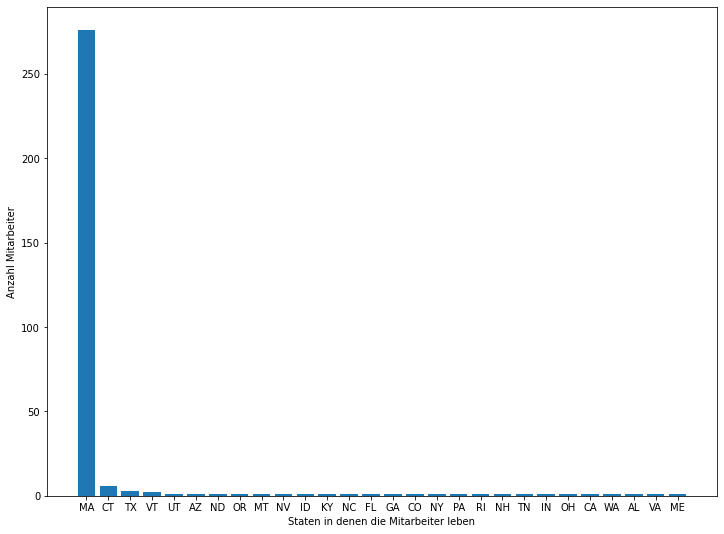

In [69]:
state = pd.DataFrame(data.State.value_counts())
statenames = state.index.values

x = np.arange(0,state.shape[0])

pp.figure(figsize=[12,9])
pp.xticks(x, statenames)
pp.ylabel("Anzahl Mitarbeiter")
pp.xlabel("Staten in denen die Mitarbeiter leben")
pp.bar(x, state["State"])

In [70]:
data[["State", "Zip"]].value_counts()

State  Zip  
MA     1886     13
       1810      7
       2176      7
       2045      7
       2451      7
                ..
       2043      1
       2031      1
       2027      1
       1938      1
WA     98052     1
Length: 158, dtype: int64

Massachusetts ist der Standort mit den meisten Mitarbeitern und die am häufigsten vorkommende PLZ ist 1886. Man könnte daran zweifeln, dass die meisten aus der direkten Umgebung eines produzierenden Betriebs kommen. Das sei aber jetzt so gegeben hahaha

### Einschub - kleine Analyse über das Unternehmen

Ich würde an dieser Stelle gerne nochmal mehr über die Situation des Unternehmens erfahren. 

In [71]:
departments = data[["State", "Department"]].value_counts()
departments 

State  Department          
MA     Production              209
       IT/IS                    44
       Software Engineering     11
       Admin Offices             9
CT     IT/IS                     5
VT     Sales                     2
TX     Sales                     2
MA     Sales                     2
AL     Sales                     1
OR     Sales                     1
NY     Sales                     1
OH     Sales                     1
PA     Sales                     1
NH     Sales                     1
RI     Sales                     1
TN     Sales                     1
TX     IT/IS                     1
UT     Sales                     1
VA     Sales                     1
NV     Sales                     1
ME     Sales                     1
ND     Sales                     1
NC     Sales                     1
MT     Sales                     1
AZ     Sales                     1
MA     Executive Office          1
KY     Sales                     1
IN     Sales               

Hier können wir sehr gut sehen, dass die Produktionsmitarbeiter in der Nähe des Unternehmenssitz sein müssen. Sollten hier große Distanzen vorkommen, würde ich diese als gefährdeter. Somit müssen wir schauen, wie die Flexibilität von Vertriebs und IT Mitarbeitern berücksichtigt werden kann. 

Eine möglichkeit sehe ich mit einer Gewichtung der Entfernung je nach Department. 

#### 3.2 Test PGeoCode

In [74]:
nomi = pgeo.Nominatim('us')
nomi.query_postal_code("0" + "1886")
# nomi.query_postal_code("36006")

postal_code               01886
country_code                 US
place_name             Westford
state_name        Massachusetts
state_code                   MA
county_name           Middlesex
county_code                17.0
community_name              NaN
community_code              NaN
latitude                42.5864
longitude              -71.4401
accuracy                    4.0
Name: 0, dtype: object

In [75]:
nomi.query_postal_code(["0" + "1886", "0" + "2027"])

,postal_code,country_code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
0,01886,US,Westford,Massachusetts,MA,Middlesex,17.0,NaN,NaN,42.5864,-71.4401,4.0
1,02027,US,Dedham,Massachusetts,MA,Norfolk,21.0,NaN,NaN,42.1800,-71.0892,4.0


In [77]:
dist = pgeo.GeoDistance('us')
dist.query_postal_code("0" + "1886", "0" + "2027")

# Ich gehe mal von Kilometern aus, weil das Beispiel aus dem Internet mit Frankreich ist. Scheint also als wäre der 
# Entwickler Europäer ist und somit kultiviert genug das metrische System zu benutzen. hahahah

53.597999301789315

Da wir bei einer Zahl nicht mit einer 0 beginnen dürfen, konvertieren wir int zu str

In [78]:
Zip_code = my_data_new["Zip"].astype("string")

#### 3.3 Erstellen einer Liste mit der Distanz von Mitarbeitern und Unternehmen 

In [79]:
dist_to_comp = []

for i in Zip_code:
    if len(i)<5:
        dist_1 = dist.query_postal_code("0" + "1886", "0" + i)
        dist_to_comp.append(dist_1)
    else:
        dist_2 = dist.query_postal_code("0" + "1886", i)
        dist_to_comp.append(dist_2)


Liste zum Dataframe konvertieren und mit der Haupttabelle joinen

In [80]:
dist_to_comp = pd.DataFrame(dist_to_comp, columns=["dist_to_comp"]).set_index(data["EmpID"])
my_data_new = my_data_new.join(dist_to_comp, how="right", rsuffix="EmpId")
my_data_new["dist_to_comp"] = my_data_new["dist_to_comp"].round(decimals=2)

### Encoding der Departments/Positions 
Hier müssen wir nochmal schauen wie wir das am besten machen, für den Übergang nehme ich einfach die Departments und gliedere die von 1-6. Den Best Practice müssen wir an der Stelle auf jeden Fall nochmal ermitteln.

#### 4.1 Festlegen der Hirarchie in einer Liste zum Ersetzen der Departments

In [82]:
dep_enc = {
    "Production       ": 1,
    "IT/IS": 2, 
    "Sales": 3,
    "Software Engineering": 4,
    "Admin Offices": 5,
    "Executive Office": 6,
}

department_enc = my_data_new["Department"].replace(dep_enc)

#### 4.2 Letzter Schliff 
Habe nochmal paar Features rausgeschmissen und die Datums Tabellen in Int's umgwandelt


In [157]:
my_data_4 = my_data_new.drop(["today", "TermReason", "Position", "MaritalDesc", "ManagerName", "Zip", "Employee_Name"], axis=1)#.join(department_enc, how="right", rsuffix="EmpId")


In [158]:
my_data_4 = my_data_4.join(data_2.PerformanceScore, how="right", rsuffix="EmpID")

In [159]:
perf_enc = {
    "Exceeds": 4,
    "Fully Meets": 3,
    "Needs Improvement": 2,
    "PIP": 1,
}

my_data_4.PerformanceScore = my_data_4.PerformanceScore.replace(perf_enc)


In [160]:
my_data_4

,GenderID,Salary,Department,EmploymentStatus,SpecialProjectsCount,DaysLateLast30,EmpSatisfaction,EngagementSurvey,Absences,time_spent,last_perf_update,age,dist_to_comp,PerformanceScore
EmpID,,,,,,,,,,,,,,
10026,1,62506,Production,1,0,0,5,4.60,1,3782,1029,39.0,39.68,4
10084,1,104437,IT/IS,0,6,0,3,4.96,17,444,113,47.0,35.70,3
10196,0,64955,Production,0,0,0,3,3.02,3,447,132,34.0,24.25,3
10088,0,64991,Production,1,0,0,5,4.84,15,5057,1043,34.0,0.00,3
10069,0,50825,Production,0,0,0,4,5.00,2,1884,218,33.0,52.20,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10135,1,65893,Production,1,0,0,4,4.07,13,2684,987,37.0,24.25,3
10301,0,48513,Production,0,0,5,2,3.20,4,2583,27,40.0,33.23,1
10010,0,220450,IT/IS,1,6,0,5,4.60,16,4233,994,43.0,57.31,4


In [161]:
my_data_4.to_csv("HR_Clean_Data", sep=",")